# CoercivityUnmixing: Skewed Gaussian Unmixing of Magnetic Coercivity
If you use this code, or adapt any part of it for your research or publications, please cite it as:

Bilardello, D. (2025). Rock-Paleo-Magnetism: Tools for processing magnetic data in paleomagnetism and rock magnetism, *GitHub*, DOI: 10.13140/RG.2.2.10602.43208, https://github.com/DBilardello/Rock-Paleo-Magnetism/tree/main/CoercivityUnmixing

**Please Note:**
- Incorporation of **any new ideas, algorithms, or implementations** from this code **into third-party software packages is strictly prohibited without permission**.
- **Attribution is required** for any use or adaptation of this code, regardless of whether the components used are standard or novel.
- **Reuse, reproduction, or redistribution** of any part of this code or its conceptual structure for inclusion in shared software tools, repositories, or frameworks **requires prior approval** from the author.

## Imported Package Versions  
This notebook was last tested with the following package versions:

- **pandas** – 2.2.3  
- **numpy** – 1.26.4  
- **matplotlib** – 3.10.0  
- **scipy** – 1.15.3  
- **IPython** – 8.30.0  
- **ipywidgets** – 8.1.5  

Using **different package versions** may result in errors or unexpected behavior. If that happens, **check the error message and adjust the code as needed**. The next cell prints the currently installed package versions for verification.

In [55]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

# Import all packages
import pandas as pd
import numpy as np
from numpy import exp, loadtxt, pi, sqrt
import csv

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.widgets import Slider
import matplotlib.gridspec as gridspec

import scipy
from scipy.optimize import curve_fit, minimize, minimize_scalar, brentq
from scipy.special import erf, owens_t
from scipy.integrate import cumulative_trapezoid, simpson
from scipy.interpolate import interp1d

import IPython
from IPython.display import display, Markdown

import os

%matplotlib widget

print("Imported Package Versions:")
print(f"pandas - {pd.__version__}")
print(f"numpy - {np.__version__}")
print(f"matplotlib  - {matplotlib.__version__}")
print(f"scipy - {scipy.__version__}")
print(f"IPython - {IPython.__version__}")

Imported Package Versions:
pandas - 2.2.3
numpy - 1.26.4
matplotlib  - 3.10.0
scipy - 1.15.3
IPython - 8.30.0


In [56]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

# ==============================================================
# Utility Functions for Coercivity Unmixing
# ==============================================================

def compute_modes_interpolated(x, components):
    """
    Compute the mode (peak location) of each component using cubic interpolation.

    Parameters
    ----------
    x : array-like
        The x-axis values (log10 µT).
    components : 2D array
        Each row (or entry) is a component curve evaluated at x.

    Returns
    -------
    modes : list
        Interpolated mode positions (log10 µT) for each component.
    """
    modes = []
    for comp in components:
        # Interpolate component for smoother peak detection
        interp_func = interp1d(x, comp, kind='cubic', bounds_error=False, fill_value="extrapolate")

        # Avoid edges where noise might dominate
        lower_bound = x[2]
        upper_bound = x[-3]

        # Find the maximum by minimizing the negative interpolated function
        res = minimize_scalar(lambda z: -interp_func(z),
                              bounds=(lower_bound, upper_bound),
                              method='bounded')

        if res.success:
            modes.append(res.x)
        else:
            # Fallback to discrete max if interpolation fails
            fallback_mode = x[np.argmax(comp)]
            print(f"⚠️ Mode minimization failed. Falling back to discrete mode: {fallback_mode:.2f}")
            modes.append(fallback_mode)
    return modes

def find_right_intersection(x, comp1, comp2, mode1, mode2, buffer=0.1):
    """
    Finds the intersection between two components to the right of mode1.

    Improvements:
    - Retries with a larger buffer if first attempt fails.
    - Warns if second attempt fails and finds no intersection.

    Parameters
    ----------
    x : array-like
        The x-axis values (log10 µT).
    comp1 : array-like
        First component curve values.
    comp2 : array-like
        Second component curve values.
    mode1, mode2 : float
        Modes (log10 µT) of each component.
    buffer : float
        Initial extra range beyond mode2 to search for intersection.

    Returns
    -------
    intersection : float
        The log10 µT position of the intersection (or none if no found).
    """

    def attempt_find(buffer_size):
        """Helper function to attempt intersection search."""
        mask = (x > mode1) & (x < (mode2 + buffer_size))
        x_masked = x[mask]

        if len(x_masked) < 2:
            return None, "not enough points"

        # Interpolators for smooth curves
        f1 = interp1d(x_masked, comp1[mask], kind='cubic',
                      bounds_error=False, fill_value='extrapolate')
        f2 = interp1d(x_masked, comp2[mask], kind='cubic',
                      bounds_error=False, fill_value='extrapolate')

        # Check for sign change (necessary for brentq)
        diff_start = f1(x_masked[0]) - f2(x_masked[0])
        diff_end = f1(x_masked[-1]) - f2(x_masked[-1])

        if diff_start * diff_end > 0:
            return None, "no sign change"

        try:
            intersection = brentq(lambda z: f1(z) - f2(z),
                                  x_masked[0], x_masked[-1])
            return intersection, None
        except ValueError as e:
            return None, f"brentq failed: {e}"

    # === First attempt with default buffer ===
    intersection, reason = attempt_find(buffer)

    # === Retry with a larger buffer if necessary ===
    if intersection is None:
        print(f"⚠️ Intersection between components failed ({reason}). Retrying with larger buffer...")
        intersection, reason = attempt_find(buffer * 3)

    # === No intersection warning and return None ===
    if intersection is None:
        print("⚠️ No intersection found after retry — skipping intersection.")
        return None
    
    return intersection

## Input File and Output Naming Convention

- This notebook reads **Backfield** or **IRM Acquisition** curves from a CSV file.  
- The input file must contain two columns with headers:
  - **`B (mT)`**: Magnetic field **must be in milliTesla (mT)**
   - **If importing IRM acquisition data**, these start at the NRM (B= 0 mT): the code automatically adds a small non-zero value of 0.001 mT (1 µT) to allow working on a log scale
  - **`M (Am2/kg)`**: Magnetization in **Am²/kg**


- Specify the input file name here:
  ```python
  datafile = 'your_input_file.csv'

- Specify the Data Type here:
  ```python
  data_type = 'backfield' or 'irm'

**All output files** (plots and CSV containing the optimized parameters) will **inherit the same base name** as the input file.

In [57]:
# ==============================================================
# Upload data file
datafile = 'test_data.csv'    # Enter the input data file name here
# ==============================================================

# ==============================================================
# Data Type Selection
data_type = "backfield"    # Enter Data Type here. Options: "backfield" or "irm"
# ==============================================================

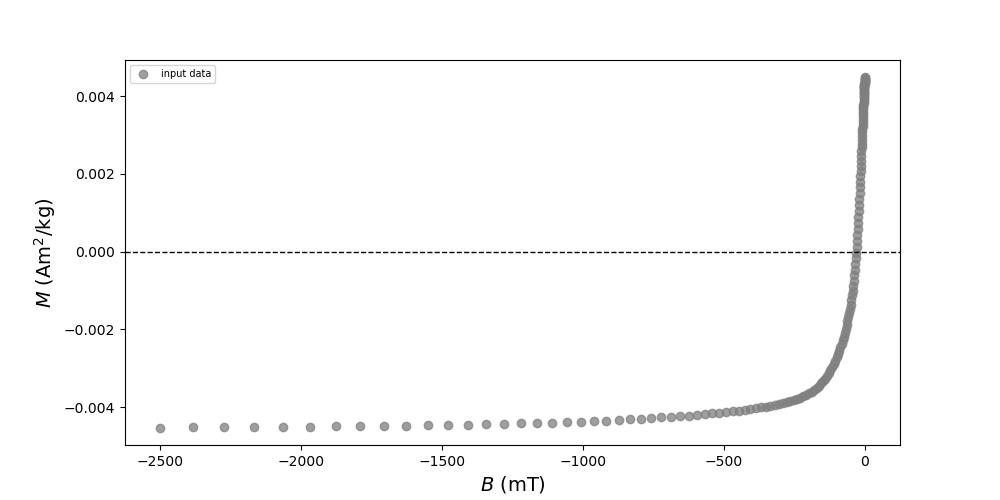

In [58]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

data = pd.read_csv(datafile)

# Get the base name without extension
base_name = os.path.splitext(os.path.basename(datafile))[0]

x = data['B (mT)'].to_numpy(dtype=float)    # Field value must be in mT
y = data['M (Am2/kg)'].to_numpy(dtype=float)

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(x, y, color='tab:gray', alpha=0.75, label='input data')
plt.legend(loc='best', fontsize=7, frameon=True)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('$B$ (mT)', fontsize=14)
plt.ylabel(r"$M$ (Am$^{2}$/kg)", fontsize=14)
plt.show()

## Convert Data Format and Field Units for Analysis

✅ Processed as Backfield data.


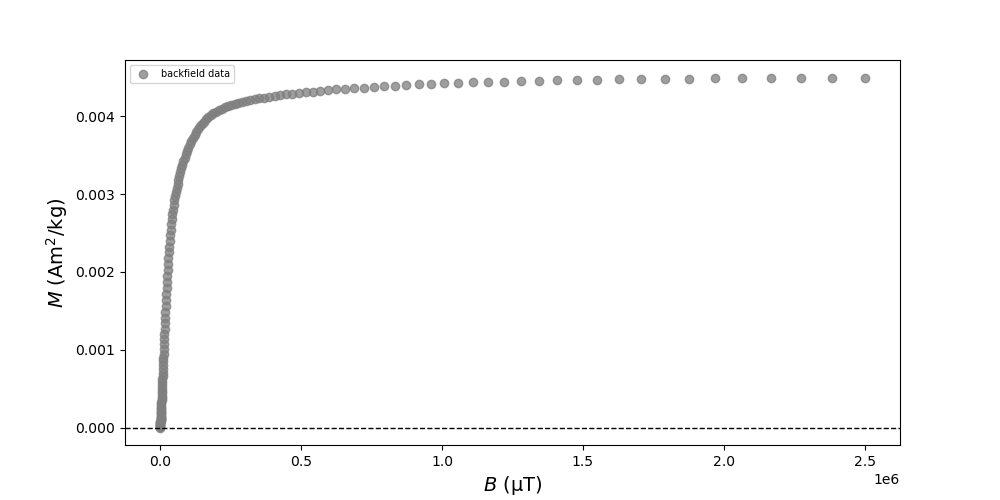

In [59]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

# ==============================================================
# Handle Data Type
# ==============================================================

if data_type == "backfield":
    # Convert Backfield curve to Acquisition-style CDF
    x_aq_uT = np.abs(x * 1000)      # Makes B positive and converts to µT
    y_aq = (-y + y[0]) / 2          # Converts Backfield to Acquisition (CDF) from 0 to Mrs
    print("✅ Processed as Backfield data.")

elif data_type == "irm":
    # Process IRM acquisition curve
    x_adj = x.copy()                # Make a copy to avoid changing the original
    x_adj[0] += 0.001               # Add small value (1 µT) to first field value to make it non-zero
    x_aq_uT = x_adj * 1000          # Convert to µT
    y_aq = (y - y[0])               # Subtracts any existing NRM baseline from acquisition data
    print("✅ Processed as IRM acquisition data.")

else:
    raise ValueError("⚠️ Invalid data_type. Use 'backfield' or 'irm'.")

# === Quick Plot for verification ===
plt.figure(figsize=(10, 5))
plt.scatter(x_aq_uT, y_aq, color='tab:gray', alpha=0.75, label=f'{data_type} data')
plt.legend(loc='best', fontsize=7, frameon=True)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel(r'$B$ (µT)', fontsize=14)
plt.ylabel(r"$M$ (Am$^{2}$/kg)", fontsize=14)
plt.show()

## Define PDF and CDF on a log scale

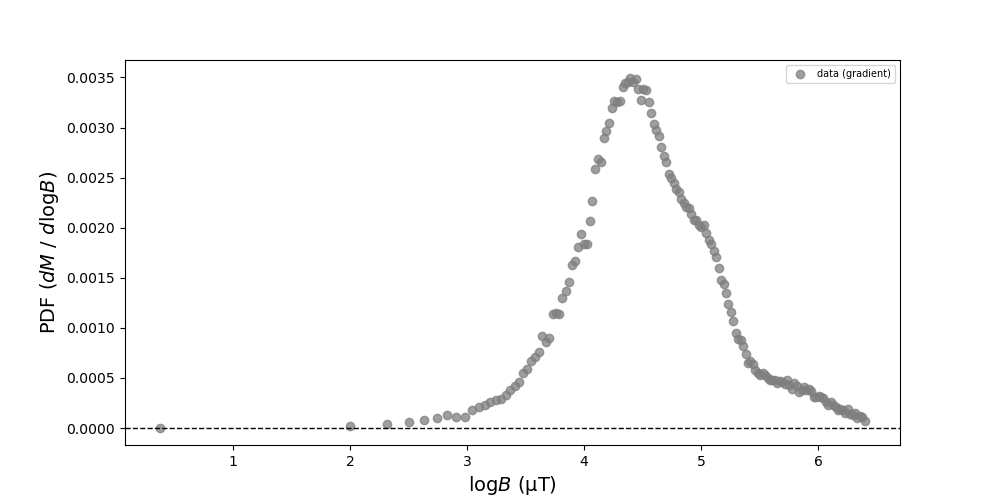

In [60]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

# Take log of x and derivative of y
x_log_uT= np.log10(x_aq_uT) # Take base 10 log of x
cdf= y_aq # Set y data as CDF
pdf= np.gradient(y_aq,x_log_uT) # Derive the PDF

# Plot PDF to view
plt.figure(figsize=(10, 5))
plt.scatter(x_log_uT, pdf, color='tab:gray', alpha=0.75, label='data (gradient)')
plt.legend(loc='best', fontsize=7, frameon=True)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel(r'log$B$ (µT)', fontsize=14)
plt.ylabel(r"PDF ($dM$ / $d$log$B$)", fontsize=14)
plt.show()

## Skewed Gaussian PDF Model Definition
$$
f(x) = \frac{A}{\sqrt{2\pi}\sigma} \exp\left( -\frac{(x - \mu)^2}{2\sigma^2} \right) 
\left[ 1 + \operatorname{erf} \left( -\frac{\alpha(x - \mu)}{\sqrt{2} \sigma} \right) \right]
$$
- $A$: Amplitude (scales the curve height)
- $\mu$: Center  
- $\sigma$: Dispersion (standard deviation of the Gaussian core)  
- $\alpha$: Skewness (controls asymmetry)
- $\operatorname{erf}$: Gaussian Error function

## Skewed Gaussian CDF Model Definition
$$
\text{CDF}(x) = A \left[ \frac{1}{2} \left(1 + \operatorname{erf}\left(\frac{x - \mu}{\sqrt{2} \sigma} \right) \right) - 2 \cdot T\left( \frac{x - \mu}{\sigma}, \alpha \right) \right]
$$
- $A$: Amplitude (same parameter as in the PDF)
- $\mu$: Center (shared with PDF for consistency)
- $\sigma$: Dispersion (shared with PDF)
- $\alpha$: Skewness (shared with PDF)
- $\operatorname{erf}$: Error function
- $T(h, a)$: Owen’s T-function, defined as
$$
T(h, a) = \frac{1}{2\pi} \int_0^a \frac{e^{-\frac{1}{2} h^2(1 + t^2)}}{1 + t^2} , dt
$$
where
- $h = \frac{x - \mu}{\sigma}$: Standardized distance from the center
- $x$: Independent variable (log-scaled field, e.g., $\log_{10} B$)
- t: Dummy variable of integration

## Key Notes
- The **PDF and CDF share the same parameter set** $(A, \mu, \sigma, \alpha)$.
- The **PDF** represents the gradient of magnetization with respect to the log field, while the **CDF** represents the integrated magnetization signal.
- Skewness is introduced through the **error function** in the PDF and through **Owen’s T-function** in the CDF, allowing asymmetry around the center $\mu$.
- The shared parameters ensure that when the PDF is optimized and refined iteratively with the CDF, both models remain fully consistent.
- Monte Carlo simulations use these shared parameters to propagate uncertainties and generate confidence envelopes for both PDF and CDF plots.

In [61]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

# ==============================================================
# Skewed Gaussian PDF Model
# ==============================================================
def skewed_gaussian(x, amplitude, center, sigma, skew):
    """Skewed Gaussian PDF component."""
    norm = amplitude / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(x - center) ** 2 / (2 * sigma ** 2))
    erf_term = (1 + erf(-skew * (x - center) / (np.sqrt(2) * sigma)))
    return norm * erf_term

def model(x, params, n_components):
    """Build total PDF from parameters."""
    y = np.zeros_like(x)
    for i in range(n_components):
        amp, cen, sig, skw = params[i*4:i*4+4]
        y += skewed_gaussian(x, amp, cen, sig, skw)
    return y

# ==============================================================
# Skewed Gaussian CDF Model
# ==============================================================
def skewed_gaussian_cdf(x, amplitude, center, sigma, skew):
    """Skewed Gaussian CDF component."""
    skew = -skew  # reverse sign for CDF definition
    erf_term_cdf = (1 + erf((x - center) / (np.sqrt(2) * sigma)))
    owen_term = 2 * owens_t((x - center) / sigma, skew)
    return amplitude * (0.5 * erf_term_cdf - owen_term)

def cdf_model(x, params, n_components):
    """Build total CDF from parameters."""
    y = np.zeros_like(x)
    for i in range(n_components):
        amp, cen, sig, skw = params[i*4:i*4+4]
        y += skewed_gaussian_cdf(x, amp, cen, sig, skw)
    return y

## Define the Interactive Widget with Field in mT

In [62]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

def interactive_guess_matplotlib(n_components):
    """
    Interactive slider-based parameter guessing for skewed Gaussian fitting.

    Parameters:
        n_components (int): Number of skewed Gaussian components to fit.
                            This must be provided when calling the function in the following code cell,
                            example: interactive_guess_matplotlib(n_components=2)

    Displays center in log10(mT); internally converts to log10(µT).
    """
    global initial_params, n_active_components
    n_active_components = n_components

    amp_scale = np.max(pdf)
    # Tableau 10 colors, skipping tab:blue (index 0)
    component_colors = [
    'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
    'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    
    # === Generate initial parameters ===
    if 'initial_params' in globals() and len(initial_params) == n_components * 4:
        # Reuse prior values (in log10(µT)) and convert back to log10(mT) for sliders
        defaults = []
        for i in range(n_components):
            amp = initial_params[i*4]
            center_log_uT = initial_params[i*4 + 1]
            sigma = initial_params[i*4 + 2]
            skew = initial_params[i*4 + 3]
            center_log_mT = center_log_uT - 3  # µT → mT for display
            defaults.append([amp, center_log_mT, sigma, skew])
    else:
        # Generate new default guesses
        center_start_mT = 1.0   # log10(1 mT) = 1.0
        center_step = 0.2       # in log10(mT)
        defaults = []
        for i in range(n_components):
            center_log_mT = center_start_mT + i * center_step
            sigma = 0.5
            skew = 0.0
            amp = 0.00
            defaults.append([amp, center_log_mT, sigma, skew])
    # Internally convert center from log10(mT) → log10(µT)
    params = []
    for amp, center_log_mT, sigma, skew in defaults:
        center_log_uT = center_log_mT + 3
        params.extend([amp, center_log_uT, sigma, skew])

    # === Set up layout using GridSpec ===
    slider_rows_per_component = 4
    slider_rows = n_components * slider_rows_per_component
    plot_rows = max(6, slider_rows // 2)
    buffer_rows = 2
    total_rows = plot_rows + buffer_rows + slider_rows

    fig = plt.figure(figsize=(9, 0.4 * total_rows + 3))
    height_ratios = [2] * plot_rows + [1] * buffer_rows + [1] * slider_rows
    gs = gridspec.GridSpec(total_rows, 1, figure=fig, height_ratios=height_ratios)

    # === Plot ===
    x_log_mT = x_log_uT - 3  # Shift to log10(mT)

    ax = fig.add_subplot(gs[:plot_rows])
    ax.scatter(x_log_mT, pdf, color='gray', label='Data (gradient)', alpha=0.75)
    model_line, = ax.plot(x_log_mT, model(x_log_uT, params, n_components), color='tab:blue', label='Mean Fit')
    comp_lines = []
    for i in range(n_components):
        color = component_colors[i % len(component_colors)]
        line, = ax.plot(x_log_mT, skewed_gaussian(x_log_uT, *params[i*4:i*4+4]), color=color)
        comp_lines.append(line)
    ax.set_xlabel("log B (mT)", fontsize=12)
    ax.set_ylabel("PDF (dM / dlogB)", fontsize=12)
    ax.legend(fontsize=10)

    # === Slider ranges ===
    param_names = ['Amp', 'Center', 'Sigma', 'Skew']
    ranges = [
        (0.0, 5 * amp_scale),   # Amplitude
        (0.0, 4),             # Center in log₁₀(mT)
        (0.05, 1.0),            # Sigma
        (-5.0, 5.0)             # Skew
    ]

    sliders = []
    for i in range(n_components):
        component_color = component_colors[i % len(component_colors)]
        for j in range(slider_rows_per_component):
            slider_idx = i * slider_rows_per_component + j
            ax_slider = fig.add_subplot(gs[plot_rows + buffer_rows + slider_idx])
            val_init = defaults[i][j]
            min_val, max_val = ranges[j]
            s = Slider(
                ax_slider,
                f'{param_names[j]} {i+1}: {min_val:.2f}',
                min_val,
                max_val,
                valinit=val_init,
                valfmt="%.2f",
                color=component_color, alpha=0.9
            )
            sliders.append(s)

    # === Update logic ===
    def update(val):
        slider_vals = [s.val for s in sliders]
        new_params = []
        for i in range(n_components):
            amp = slider_vals[i*4]
            center_log_mT = slider_vals[i*4 + 1]
            sigma = slider_vals[i*4 + 2]
            skew = slider_vals[i*4 + 3]
            center_log_uT = center_log_mT + 3  # Conversion
            new_params.extend([amp, center_log_uT, sigma, skew])
        model_line.set_ydata(model(x_log_uT, new_params, n_components))
        for i in range(n_components):
            comp_lines[i].set_ydata(skewed_gaussian(x_log_uT, *new_params[i*4:i*4+4]))
        fig.canvas.draw_idle()
        initial_params[:] = new_params

    for s in sliders:
        s.on_changed(update)

    initial_params = params.copy()
    update(None)
    plt.show()

# Set the Number of Components:
- Change the n_components value in the cell below to the desired # of components to fit
- Once you run the cell, use the component sliders to fit each component

### Rule of thumb to set parameters:
- Within ~10–20% of the true values (in amplitude, center, and sigma) is usually excellent.
- Skew is trickier: if you at least capture the sign and general shape, left-skewed (positive) vs right-skewed (negative), you’re likely to converge well.

### After setting the desired parameters, do not run the cell again, move on the next cell

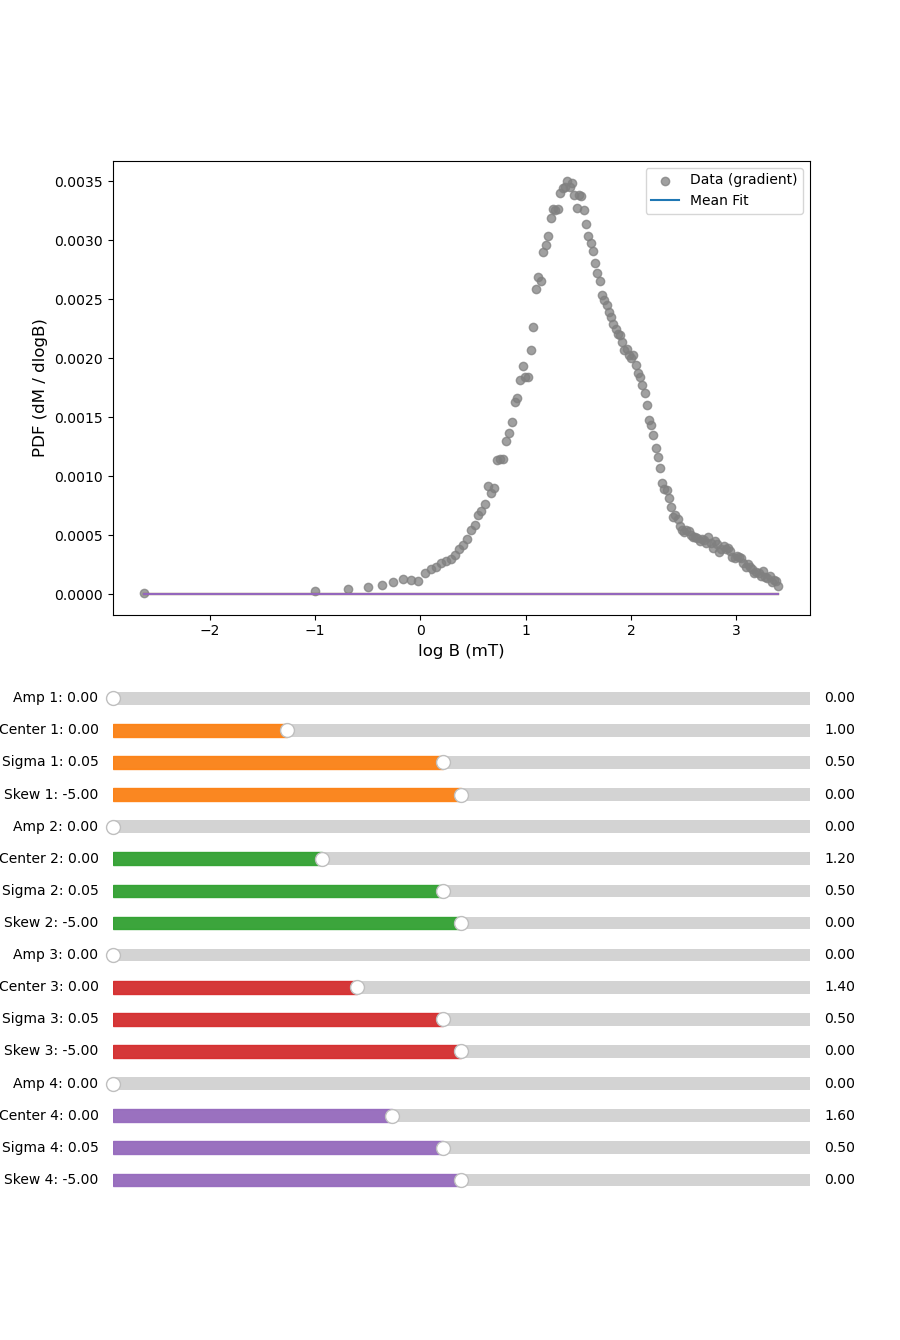

In [63]:
# ==============================================================
interactive_guess_matplotlib(n_components=4)
# ==============================================================

## Setting bounds around parameters

In [64]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

amp_scale = np.max(pdf)  # Redefine amp_scale here

# Example: define bounds per component
bounds = []
for i in range(n_active_components):
    amp_guess   = initial_params[i * 4]
    center_guess = initial_params[i * 4 + 1]
    sigma_guess = initial_params[i * 4 + 2]
    skew_guess  = initial_params[i * 4 + 3]

    # Amplitude: 0 to 1.25× initial guess
    bounds.append((0, max(amp_guess * 1.25, amp_scale * 0.05))) #bounds.append((0, amp_guess * 1.25))

    # Center: ±0.3 around guess, within limits
    bounds.append((max(center_guess - 0.3, 2.5), min(center_guess + 0.3, 7.0))) #bounds.append((max(center_guess - 0.3, 3.0), min(center_guess + 0.3, 7.0)))

    # Sigma: 0.5× initial guess but capped at 0.05 to 2× initial guess
    #bounds.append((max(0.05, sigma_guess * 0.5), sigma_guess * 2))
    sigma_lower = max(0.05, sigma_guess * 0.5) # Ensures minimum is 0.05 even if set to zero
    sigma_upper = max(sigma_lower + 0.01, sigma_guess * 2)  # Ensure valid non-zero range
    bounds.append((sigma_lower, sigma_upper))

    # Skew: ±2 from guess, capped at ±5
    bounds.append((max(-5.0, skew_guess - 2.0), min(5.0, skew_guess + 2.0)))

# PDF-CDF Iterative Optimization Loop

In [65]:
# ==============================================================
# Objective functions for PDF and CDF
# ==============================================================

def objective(params, x, pdf, n_active_components):
    """Objective: minimize relative L2 norm of residuals on the PDF."""
    y_fit = model(x, params, n_active_components)
    residuals = pdf - y_fit
    return np.linalg.norm(residuals) / np.linalg.norm(pdf)

def objective_cdf(params, x, cdf_data, n_active_components):
    """Objective: minimize relative L2 norm of residuals on the CDF."""
    y_fit = cdf_model(x, params, n_active_components)
    residuals = cdf_data - y_fit
    return np.linalg.norm(residuals) / np.linalg.norm(cdf_data)

# **************************************************************
# PDF–CDF Iterative Optimization Loop
# **************************************************************

# --- Helper optimization functions ---
def optimize_pdf(params_start):
    """Optimize PDF starting from given parameters."""
    result_pdf = minimize(
        objective, params_start, args=(x_log_uT, pdf, n_active_components),
        method='L-BFGS-B', bounds=bounds
    )
    return result_pdf

def optimize_cdf(params_start):
    """Optimize CDF starting from given parameters."""
    result_cdf = minimize(
        objective_cdf, params_start, args=(x_log_uT, cdf, n_active_components),
        method='L-BFGS-B', bounds=bounds
    )
    return result_cdf

# --- Iteration control ---
tolerance = 1e-5         # Stop when improvement is negligible
max_iterations = 10
params = initial_params.copy()

prev_total_cost = np.inf

for iteration in range(max_iterations):
    print(f"\n=== Iteration {iteration+1} ===")

    # --- PDF optimization ---
    result_pdf = optimize_pdf(params)
    params = result_pdf.x
    pdf_cost = result_pdf.fun

    # --- CDF optimization ---
    result_cdf = optimize_cdf(params)
    params = result_cdf.x
    cdf_cost = result_cdf.fun

    # --- Total cost ---
    total_cost = pdf_cost + cdf_cost
    improvement = prev_total_cost - total_cost
    print(f"PDF cost: {pdf_cost:.6f}, CDF cost: {cdf_cost:.6f}, total: {total_cost:.6f}")

    if improvement < tolerance:
        print(f"\n✅ Converged after {iteration+1} iterations (Δcost={improvement:.6g})")
        break

    prev_total_cost = total_cost

else:
    print(f"\n⚠️ Max iterations ({max_iterations}) reached without full convergence.")

# ✅ Final optimized parameters after loop
optimized_params_final = params
optimized_params_cdf = optimized_params_final.copy()  # Keep naming consistent for plotting

# ==============================================================
# Compute final fits & residuals after iterative optimization
# ==============================================================

# PDF best-fit and residuals
pdf_best_fit = model(x_log_uT, optimized_params_final, n_active_components)
pdf_residuals = pdf - pdf_best_fit

# CDF best-fit and residuals
cdf_best_fit = cdf_model(x_log_uT, optimized_params_final, n_active_components)
cdf_residuals = cdf - cdf_best_fit


=== Iteration 1 ===
PDF cost: 0.027706, CDF cost: 0.003785, total: 0.031491

=== Iteration 2 ===
PDF cost: 0.027707, CDF cost: 0.003786, total: 0.031493

✅ Converged after 2 iterations (Δcost=-1.6032e-06)


### Iterative Optimization Output Explanation
The PDF–CDF optimization loop alternates between fitting the PDF (gradient data) and the CDF (cumulative data), refining the shared parameters ($A$, $\mu$, $\sigma$, $\alpha$) at each step.
- **PDF cost:** misfit between the model PDF and data
- **CDF cost:** misfit between the model CDF and data
- **Total cost:** sum of PDF and CDF costs, tracking overall improvement

Across iterations, the total cost typically decreases quickly at first, then levels off. When further improvement becomes negligible, the loop stops, yielding a single, consistent parameter set that fits both the PDF and CDF.

# Post-Iteration Monte Carlo, Modes & Intersections Block
## Set Number of Monte Carlo Simulations:
- 500–1000 simulations are recommended for stability of the confidence bands.
- Fewer simulations (e.g. 100) can be used during development or for quicker runs, but may result in noisy uncertainty envelopes.

In [66]:
# ==============================================================
monte_carlo_simulations= 1000    # Enter N of simulations here
# ==============================================================

In [67]:
# **************************************************************
# Monte Carlo Simulations, Modes, and Intersections
# **************************************************************

# === Best-fit PDF from converged parameters ===
pdf_best_fit = model(x_log_uT, optimized_params_final, n_active_components)

# === PDF components individually ===
pdf_comps = np.zeros((n_active_components, len(x_log_uT)))
for i in range(n_active_components):
    amp = optimized_params_final[i * 4]
    cen = optimized_params_final[i * 4 + 1]
    sig = optimized_params_final[i * 4 + 2]
    skw = optimized_params_final[i * 4 + 3]
    pdf_comps[i, :] = skewed_gaussian(x_log_uT, amp, cen, sig, skw)

# === Compute PDF residuals ===
pdf_residuals = pdf - pdf_best_fit

# === Compute modes ===
modes_pdf = []
for idx, comp in enumerate(pdf_comps):
    interp_func = interp1d(x_log_uT, comp, kind='cubic',
                           bounds_error=False, fill_value="extrapolate")

    max_val = np.max(comp)
    if max_val == 0:
        print(f"⚠️ Component {idx+1} is flat — mode set to lower bound")
        modes_pdf.append(x_log_uT[0])
        continue

    region_mask = comp > (0.05 * max_val)
    search_x = x_log_uT[region_mask]

    if len(search_x) > 2:
        lower_bound = search_x[0]
        upper_bound = search_x[-1]
    else:
        lower_bound = x_log_uT[0]
        upper_bound = x_log_uT[-1]

    res = minimize_scalar(lambda z: -interp_func(z),
                          bounds=(lower_bound, upper_bound),
                          method='bounded')

    if res.success:
        modes_pdf.append(res.x)
    else:
        fallback = x_log_uT[np.argmax(comp)]
        print(f"⚠️ Mode minimization failed for component {idx+1}, fallback to discrete mode {fallback:.3f}")
        modes_pdf.append(fallback)

modes_pdf_mT = [10**(m - 3) for m in modes_pdf]

# === Compute intersections ===
intersections_log_uT = []
intersections_mT = []

for i in range(n_active_components - 1):
    mode1 = modes_pdf[i]
    mode2 = modes_pdf[i + 1]
    intersection = find_right_intersection(
        x_log_uT, pdf_comps[i], pdf_comps[i + 1], mode1, mode2
    )
    intersections_log_uT.append(intersection)
    if intersection is not None:
        intersections_mT.append(10**(intersection - 3))
    else:
        intersections_mT.append(None)

print("\n✅ Mode & intersection calculation complete.")

# === Monte Carlo simulations for the PDF ===
sigma_noise_pdf = np.std(pdf - pdf_best_fit)

simulated_pdf_fits = np.zeros((monte_carlo_simulations, len(x_log_uT)))
simulated_pdf_comps = np.zeros((monte_carlo_simulations, n_active_components, len(x_log_uT)))
simulated_pdf_params = np.zeros((monte_carlo_simulations, n_active_components * 4))

np.random.seed(88)  # reproducibility

for i in range(monte_carlo_simulations):
    noisy_pdf = pdf + np.random.normal(0, sigma_noise_pdf, size=pdf.shape)
    result_noisy_pdf = minimize(
        lambda p: np.linalg.norm(noisy_pdf - model(x_log_uT, p, n_active_components)) /
                  np.linalg.norm(noisy_pdf),
        optimized_params_final, method='L-BFGS-B', bounds=bounds
    )
    simulated_pdf_params[i, :] = result_noisy_pdf.x
    best_fit_noisy_pdf = model(x_log_uT, result_noisy_pdf.x, n_active_components)
    simulated_pdf_fits[i, :] = best_fit_noisy_pdf

    for j in range(n_active_components):
        amp = result_noisy_pdf.x[j * 4]
        cen = result_noisy_pdf.x[j * 4 + 1]
        sig = result_noisy_pdf.x[j * 4 + 2]
        skw = result_noisy_pdf.x[j * 4 + 3]
        simulated_pdf_comps[i, j, :] = skewed_gaussian(x_log_uT, amp, cen, sig, skw)

# === Compute PDF MC stats ===
mean_pdf_fit = np.mean(simulated_pdf_fits, axis=0)
std_pdf_fit  = np.std(simulated_pdf_fits, axis=0)
mean_pdf_comps = np.mean(simulated_pdf_comps, axis=0)
std_pdf_comps  = np.std(simulated_pdf_comps, axis=0)

# === Generate CDF components from PDF MC parameters ===
simulated_cdf_comps_from_pdf = np.zeros_like(simulated_pdf_comps)
simulated_cdf_fits_from_pdf = np.zeros_like(simulated_pdf_fits)

for i in range(monte_carlo_simulations):
    for j in range(n_active_components):
        amp = simulated_pdf_params[i, j * 4]
        cen = simulated_pdf_params[i, j * 4 + 1]
        sig = simulated_pdf_params[i, j * 4 + 2]
        skw = simulated_pdf_params[i, j * 4 + 3]
        simulated_cdf_comps_from_pdf[i, j, :] = skewed_gaussian_cdf(x_log_uT, amp, cen, sig, skw)

    simulated_cdf_fits_from_pdf[i, :] = simulated_cdf_comps_from_pdf[i].sum(axis=0)

# === Compute CDF MC stats ===
mean_cdf_comps = np.mean(simulated_cdf_comps_from_pdf, axis=0)
std_cdf_comps  = np.std(simulated_cdf_comps_from_pdf, axis=0)
mean_cdf_fit   = np.mean(simulated_cdf_fits_from_pdf, axis=0)
std_cdf_fit    = np.std(simulated_cdf_fits_from_pdf, axis=0)

print("\n✅ Monte Carlo finished. Final PDF & CDF MC fits ready.")


✅ Mode & intersection calculation complete.

✅ Monte Carlo finished. Final PDF & CDF MC fits ready.


## Interpolation on a Finer Grid for Smooth Plotting

In [70]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

# ==============================================================
# Finer grid interpolation for plotting
# ==============================================================

# Create a finer x-axis grid for smooth plotting
x_fine_log_uT = np.linspace(x_log_uT.min(), x_log_uT.max(), 2000)
x_fine_log_mT = x_fine_log_uT - 3

def hybrid_interp(x, y):
    """Piecewise interpolation: linear for the first 2 points, cubic after."""
    x_thresh = x[1]  # Transition after first 2 points

    # Linear and cubic interpolators
    interp_linear = interp1d(x[:2], y[:2], kind='linear', fill_value='extrapolate')
    interp_cubic = interp1d(x, y, kind='cubic', fill_value='extrapolate')

    def combined_interp(x_new):
        result = np.zeros_like(x_new)
        mask_linear = x_new <= x_thresh
        result[mask_linear] = interp_linear(x_new[mask_linear])
        result[~mask_linear] = interp_cubic(x_new[~mask_linear])
        return result

    return combined_interp

# === CDF fit and std ===
cdf_interp = hybrid_interp(x_log_uT, mean_cdf_fit)
cdf_std_interp = hybrid_interp(x_log_uT, std_cdf_fit)
mean_cdf_fit_fine = cdf_interp(x_fine_log_uT)
std_cdf_fit_fine = cdf_std_interp(x_fine_log_uT)

# === CDF components ===
mean_cdf_comps_fine = []
std_cdf_comps_fine = []
for i in range(n_active_components):
    mean_interp = hybrid_interp(x_log_uT, mean_cdf_comps[i])
    std_interp = hybrid_interp(x_log_uT, std_cdf_comps[i])
    mean_cdf_comps_fine.append(mean_interp(x_fine_log_uT))
    std_cdf_comps_fine.append(std_interp(x_fine_log_uT))

# === PDF fit and std (UPDATED) ===
pdf_interp = hybrid_interp(x_log_uT, mean_pdf_fit)
pdf_std_interp = hybrid_interp(x_log_uT, std_pdf_fit)
mean_pdf_fit_fine = pdf_interp(x_fine_log_uT)
std_pdf_fit_fine = pdf_std_interp(x_fine_log_uT)

# === PDF components (UPDATED) ===
mean_pdf_comps_fine = []
std_pdf_comps_fine = []
for i in range(n_active_components):
    mean_interp = hybrid_interp(x_log_uT, mean_pdf_comps[i])
    std_interp = hybrid_interp(x_log_uT, std_pdf_comps[i])
    mean_pdf_comps_fine.append(mean_interp(x_fine_log_uT))
    std_pdf_comps_fine.append(std_interp(x_fine_log_uT))

# Plotting:
### Data Types
- **CDF (Cumulative Distribution Function):** Original measurement data.
- **PDF (Probability Density Function):** Derived by computing the gradient of the CDF with respect to log B. Highlights individual components and inflection points more clearly.

### PDF Component Intersections
If component Modes are distinct, **PDF plots** feature vertical lines marking the **intersection points between adjacent components**, with the field values listed. These values are useful for deriving rock-magnetic parameters (e.g., **s-ratios**, **HIRM**) and for conducting subsequent experiments such as the **Goethite Test** (**classic** and **HIRM-based**). Note that the algorithm may fail to return intersections when adjacent peaks (Modes) are too close or poorly resolved.

# Plots:
### Plots 1 & 2 – CDF & PDF for full Diagnostic Overview
To evaluate model performance and fit quality:
 - CDF with fitted curve and confidence bounds
 - CDF residuals
 - PDF with component fits, mean fit, and error bounds
 - PDF residuals (typically larger due to higher noise)
This plot offers a comprehensive overview across both domains and is useful for initial diagnostics.

### Plots 3–4 – Recommended for Publication (e.g., PDF in Main Text, CDF in Supplementary Information)
 - Plot 3- PDF: with individual components, mean fit, confidence bounds, and residuals
 - Plot 4- CDF: with individual components, mean fit, confidence bounds, and residuals

# Note: Reordering Plots in the Notebook
You can fully **customize the plot order** by rearranging notebook cells:
- **Click on the cell** you want to move **to enter Command Mode** (the cell border turns blue).
- **Use the Up or Down arrows in the toolbar** at the top of the notebook to move the cell to a new position.

This allows you to group or sequence plots in any order you prefer.

# Select a Common File Format to Save the Plots:

In [71]:
# ==============================================================
# Plot Format Selection
save_format = "png"  # Select a format for all output figure files. 
# ==============================================================

# Recommended Options: 
# - "png", best for notebooks, presentations, web
# - "jpg" or "jpeg", smaller file size
# - "tiff", high quality images, best for publishing
# - "pdf" or "svg", vector formats for publishing, printing or editing
# ==============================================================

## Plot 1: CDF & PDF

Figure saved as: test_data_CDF&PDF_1.png


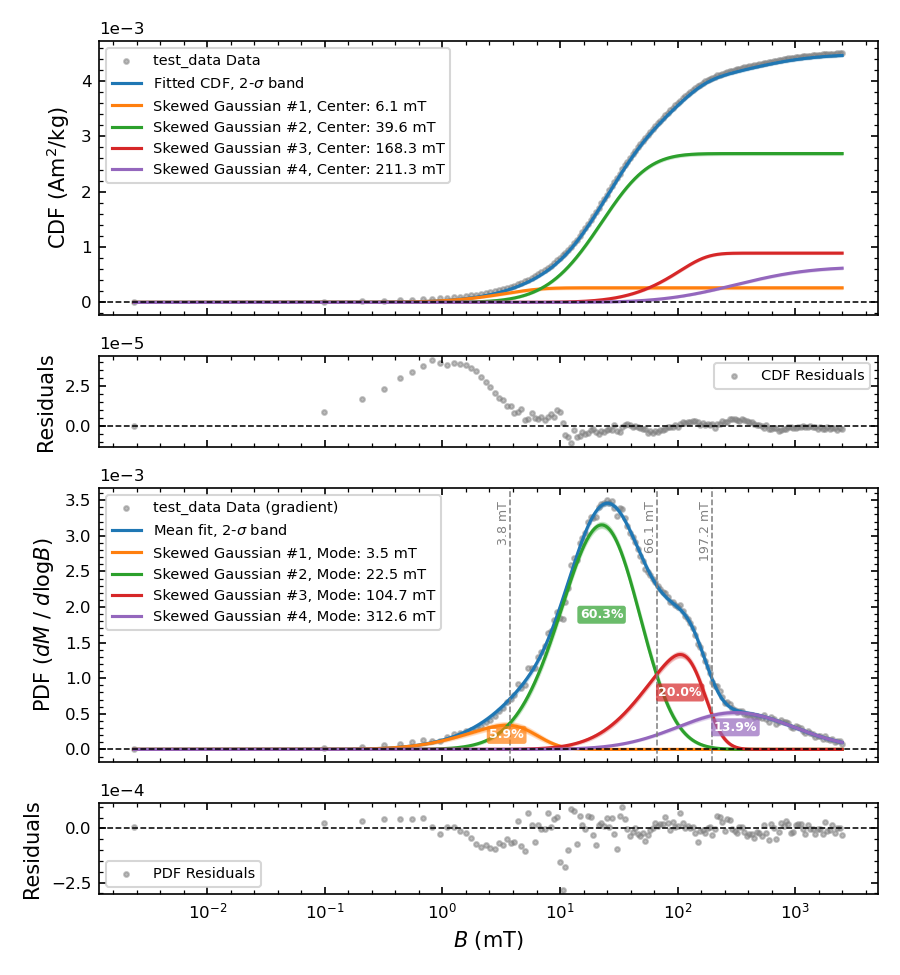

In [72]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

# CDF & PDF Plot 1

fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    4, 1, figsize=(6, 6.5), dpi=150, sharex=True,
    gridspec_kw={'height_ratios': [3, 1, 3, 1]}
)

x_log_mT = x_log_uT - 3    # Convert to log10(mT) for plotting

# Use Tableau colors (skipping tab:blue)
component_colors = list(plt.cm.tab10.colors[1:])

# =====================================================
# CDF Plot
# =====================================================
ax1.scatter(x_log_mT, cdf, color='tab:gray', s=5, alpha=0.5, label=f"{base_name} Data")
ax1.plot(x_fine_log_mT, mean_cdf_fit_fine, '-', color='tab:blue', linewidth=1.5, label='Fitted CDF, 2-$\sigma$ band')
ax1.fill_between(x_fine_log_mT, mean_cdf_fit_fine - std_cdf_fit_fine, mean_cdf_fit_fine + std_cdf_fit_fine,
                 color='tab:blue', alpha=0.25)
ax1.set_ylabel(r'CDF (Am$^2$/kg)', fontsize=10)

# Plot each CDF component
for i in range(n_active_components):
    amp, cen, sig, skw = optimized_params_cdf[i*4:i*4+4]

    # Round log BEFORE converting to mT for consistency
    center_log_mT_r = round(cen - 3, 3)
    center_mT_r = round(10**center_log_mT_r, 1)

    color = component_colors[i % len(component_colors)]
    ax1.plot(x_fine_log_mT, mean_cdf_comps_fine[i], color=color,
             label=f'Skewed Gaussian #{i+1}, Center: {center_mT_r:.1f} mT')
    ax1.fill_between(x_fine_log_mT,
                     mean_cdf_comps_fine[i] - std_cdf_comps_fine[i],
                     mean_cdf_comps_fine[i] + std_cdf_comps_fine[i],
                     color=color, alpha=0.25)

ax1.legend(loc='best', fontsize=7, frameon=True)
ax1.axhline(0, color='black', linestyle='--', linewidth=0.75)

# =====================================================
# CDF Residuals Plot
# =====================================================
ax2.scatter(x_log_mT, cdf_residuals, color='tab:gray', s=5, alpha=0.5, label='CDF Residuals')
ax2.set_ylabel('Residuals', fontsize=10)
ax2.legend(loc='best', fontsize=7, frameon=True)
ax2.axhline(0, color='black', linestyle='--', linewidth=0.75)

# =====================================================
# PDF Plot
# =====================================================
ax3.scatter(x_log_mT, pdf, color='tab:gray', s=5, alpha=0.5, label=f"{base_name} Data Gradient")
ax3.plot(x_fine_log_mT, mean_pdf_fit_fine, '-', linewidth=1.5, color='tab:blue', label=r'Mean fit, 2-$\sigma$ band')
ax3.fill_between(x_fine_log_mT, mean_pdf_fit_fine - 2 * std_pdf_fit_fine, mean_pdf_fit_fine + 2 * std_pdf_fit_fine,
                 color='tab:blue', alpha=0.25)

# Plot each PDF component (with modes)
for i in range(n_active_components):
    mode = modes_pdf[i]

    # Round mode log BEFORE converting
    mode_log_mT_r = round(mode - 3, 3)
    mode_mT_r = round(10**mode_log_mT_r, 1)

    color = component_colors[i % len(component_colors)]
    ax3.plot(x_fine_log_mT, mean_pdf_comps_fine[i], color=color, linewidth=1.5,
             label=f'Skewed Gaussian #{i+1}, Mode: {mode_mT_r:.1f} mT')
    ax3.fill_between(x_fine_log_mT,
                     mean_pdf_comps_fine[i] - 2 * std_pdf_comps_fine[i],
                     mean_pdf_comps_fine[i] + 2 * std_pdf_comps_fine[i],
                     color=color, alpha=0.25)

# === Plot stored intersections as lines + labels ===
for i, intersection in enumerate(intersections_log_uT):
    if intersection is not None:
        # Round intersection log BEFORE converting
        intersection_log_mT_r = round(intersection - 3, 3)
        intersection_mT_r = round(10**intersection_log_mT_r, 1)

        ax3.axvline(intersection_log_mT_r, color='gray', linestyle='--', linewidth=0.75)
        ax3.text(intersection_log_mT_r, ax3.get_ylim()[1]*0.95, f'{intersection_mT_r:.1f} mT',
                 rotation=90, fontsize=6, color='gray', ha='right', va='top')

# Calculate % contribution using smooth data
component_areas = [simpson(comp, x_fine_log_uT) for comp in mean_pdf_comps_fine]
total_component_area = sum(component_areas)
component_props = [a / total_component_area for a in component_areas]

# Annotate % labels inside each PDF curve
for i in range(n_active_components):
    color = component_colors[i % len(component_colors)]
    comp = mean_pdf_comps_fine[i]
    peak_idx = np.argmax(comp)
    x_label = x_fine_log_mT[peak_idx]
    y_label = comp[peak_idx] * 0.6
    percent = component_props[i] * 100
    ax3.text(x_label, y_label, f"{percent:.1f}%", fontsize=6,
             ha='center', va='center', color='white', weight='bold',
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7))

ax3.set_ylabel(r"PDF ($dM$ / $d$log$B$)", fontsize=10)
ax3.axhline(0, color='black', linestyle='--', linewidth=0.75)
ax3.legend(loc='best', fontsize=7, frameon=True)

# =====================================================
# PDF Residuals Plot
# =====================================================
ax4.scatter(x_log_mT, pdf_residuals, color='tab:gray', s=5, alpha=0.5, label='PDF Residuals')
ax4.axhline(0, color='black', linestyle='--', linewidth=0.75)
ax4.legend(loc='best', fontsize=7, frameon=True)
ax4.set_ylabel('Residuals', fontsize=10)
ax4.set_xlabel(r'$B$ (mT)', fontsize=10)

# =====================================================
# Apply consistent formatting to all subplots
# =====================================================
for ax in [ax1, ax2, ax3, ax4]:
    ax.minorticks_on()
    ax.tick_params(which='both', labelsize=8, top=True, right=True, direction='in')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(8)

# === Tidy up X-axis (log labels) ===
def log_formatter(x, pos):
    if np.isclose(x, round(x), atol=1e-6):
        return f'$10^{{{int(x)}}}$'
    else:
        return ''
for ax in [ax1, ax2, ax3, ax4]:
    ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))

# ==============================================================
# Final layout and Save
# ==============================================================
fig.tight_layout()

fig_name = f"{base_name}_CDF&PDF_1.{save_format}"
plt.savefig(fig_name, dpi=300, bbox_inches='tight')
print(f"Figure saved as: {fig_name}")

plt.show()

Figure saved as: test_data_PDF&CDF_2.png


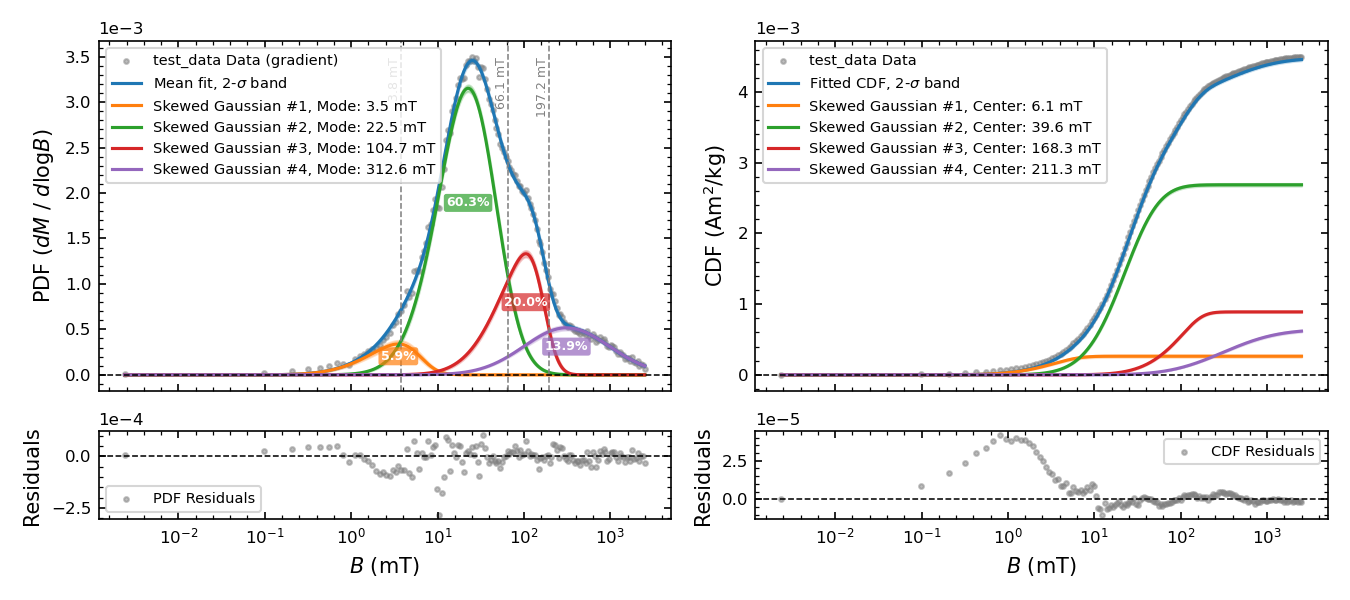

In [74]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

# PDF & CDF Plot 2

fig, axes = plt.subplots(2, 2, figsize=(9, 4), dpi=150, sharex=True,
                         gridspec_kw={'height_ratios': [3, 0.75]})

ax1, ax2, ax3, ax4 = axes.flatten()

x_log_mT = x_log_uT - 3    # Convert to log10(mT) for plotting

# Use Tableau colors (skipping tab:blue)
component_colors = list(plt.cm.tab10.colors[1:])

# =====================================================
# CDF Plot
# =====================================================
ax2.scatter(x_log_mT, cdf, color='tab:gray', s=5, alpha=0.5, label=f"{base_name} Data")
ax2.plot(x_fine_log_mT, mean_cdf_fit_fine, '-', color='tab:blue', linewidth=1.5, label='Fitted CDF, 2-$\sigma$ band')
ax2.fill_between(x_fine_log_mT, mean_cdf_fit_fine - std_cdf_fit_fine, mean_cdf_fit_fine + std_cdf_fit_fine,
                 color='tab:blue', alpha=0.25)
ax2.set_ylabel(r'CDF (Am$^2$/kg)', fontsize=10)

# Plot each CDF component (rounded first for consistency)
for i in range(n_active_components):
    amp, cen, sig, skw = optimized_params_cdf[i*4:i*4+4]

    # Round log first
    center_log_mT_r = round(cen - 3, 3)
    center_mT_r = round(10**center_log_mT_r, 1)

    color = component_colors[i % len(component_colors)]
    ax2.plot(x_fine_log_mT, mean_cdf_comps_fine[i], color=color,
             label=f'Skewed Gaussian #{i+1}, Center: {center_mT_r:.1f} mT')
    ax2.fill_between(x_fine_log_mT,
                     mean_cdf_comps_fine[i] - std_cdf_comps_fine[i],
                     mean_cdf_comps_fine[i] + std_cdf_comps_fine[i],
                     color=color, alpha=0.25)

ax2.legend(loc='best', fontsize=7, frameon=True)
ax2.axhline(0, color='black', linestyle='--', linewidth=0.75)

# =====================================================
# CDF Residuals Plot
# =====================================================
ax4.scatter(x_log_mT, cdf_residuals, color='tab:gray', s=5, alpha=0.5, label='CDF Residuals')
ax4.set_ylabel('Residuals', fontsize=10)
ax4.legend(loc='best', fontsize=7, frameon=True)
ax4.axhline(0, color='black', linestyle='--', linewidth=0.75)
ax4.set_xlabel(r'$B$ (mT)', fontsize=10)

# =====================================================
# PDF Plot
# =====================================================
ax1.scatter(x_log_mT, pdf, color='tab:gray', s=5, alpha=0.5, label=f"{base_name} Data Gradient")
ax1.plot(x_fine_log_mT, mean_pdf_fit_fine, '-', linewidth=1.5, color='tab:blue', label=r'Mean fit, 2-$\sigma$ band')
ax1.fill_between(x_fine_log_mT, mean_pdf_fit_fine - 2 * std_pdf_fit_fine, mean_pdf_fit_fine + 2 * std_pdf_fit_fine,
                 color='tab:blue', alpha=0.25)

# Plot each PDF component (with rounded modes)
for i in range(n_active_components):
    mode = modes_pdf[i]

    # Round log first
    mode_log_mT_r = round(mode - 3, 3)
    mode_mT_r = round(10**mode_log_mT_r, 1)

    color = component_colors[i % len(component_colors)]
    ax1.plot(x_fine_log_mT, mean_pdf_comps_fine[i], color=color, linewidth=1.5,
             label=f'Skewed Gaussian #{i+1}, Mode: {mode_mT_r:.1f} mT')
    ax1.fill_between(x_fine_log_mT,
                     mean_pdf_comps_fine[i] - 2 * std_pdf_comps_fine[i],
                     mean_pdf_comps_fine[i] + 2 * std_pdf_comps_fine[i],
                     color=color, alpha=0.25)

# === Plot stored intersections as lines + labels (rounded too) ===
for i, intersection in enumerate(intersections_log_uT):
    if intersection is not None:
        intersection_log_mT_r = round(intersection - 3, 3)
        intersection_mT_r = round(10**intersection_log_mT_r, 1)

        ax1.axvline(intersection_log_mT_r, color='gray', linestyle='--', linewidth=0.75)
        ax1.text(intersection_log_mT_r, ax1.get_ylim()[1]*0.95, f'{intersection_mT_r:.1f} mT',
                 rotation=90, fontsize=6, color='gray', ha='right', va='top')

# Calculate % contribution using smooth data
component_areas = [simpson(comp, x_fine_log_uT) for comp in mean_pdf_comps_fine]
total_component_area = sum(component_areas)
component_props = [a / total_component_area for a in component_areas]

# Annotate % labels inside each PDF curve
for i in range(n_active_components):
    color = component_colors[i % len(component_colors)]
    comp = mean_pdf_comps_fine[i]
    peak_idx = np.argmax(comp)
    x_label = x_fine_log_mT[peak_idx]
    y_label = comp[peak_idx] * 0.6
    percent = component_props[i] * 100
    ax1.text(x_label, y_label, f"{percent:.1f}%", fontsize=6,
             ha='center', va='center', color='white', weight='bold',
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7))

ax1.set_ylabel(r"PDF ($dM$ / $d$log$B$)", fontsize=10)
ax1.axhline(0, color='black', linestyle='--', linewidth=0.75)
ax1.legend(loc='best', fontsize=7, frameon=True)

# =====================================================
# PDF Residuals Plot
# =====================================================
ax3.scatter(x_log_mT, pdf_residuals, color='tab:gray', s=5, alpha=0.5, label='PDF Residuals')
ax3.axhline(0, color='black', linestyle='--', linewidth=0.75)
ax3.legend(loc='best', fontsize=7, frameon=True)
ax3.set_ylabel('Residuals', fontsize=10)
ax3.set_xlabel(r'$B$ (mT)', fontsize=10)

# =====================================================
# Apply consistent formatting to all subplots
# =====================================================
for ax in [ax1, ax2, ax3, ax4]:
    ax.minorticks_on()
    ax.tick_params(which='both', labelsize=8, top=True, right=True, direction='in')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(8)

# === Tidy up X-axis (log labels) ===
def log_formatter(x, pos):
    if np.isclose(x, round(x), atol=1e-6):
        return f'$10^{{{int(x)}}}$'
    else:
        return ''
for ax in [ax1, ax2, ax3, ax4]:
    ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))

# ==============================================================
# Final layout and Save
# ==============================================================
fig.tight_layout()

fig_name = f"{base_name}_PDF&CDF_2.{save_format}"
plt.savefig(fig_name, dpi=300)  # bbox_inches='tight' optional
print(f"Figure saved as: {fig_name}")

plt.show()

### Plot 3: PDF

Figure saved as: test_data_PDF.png


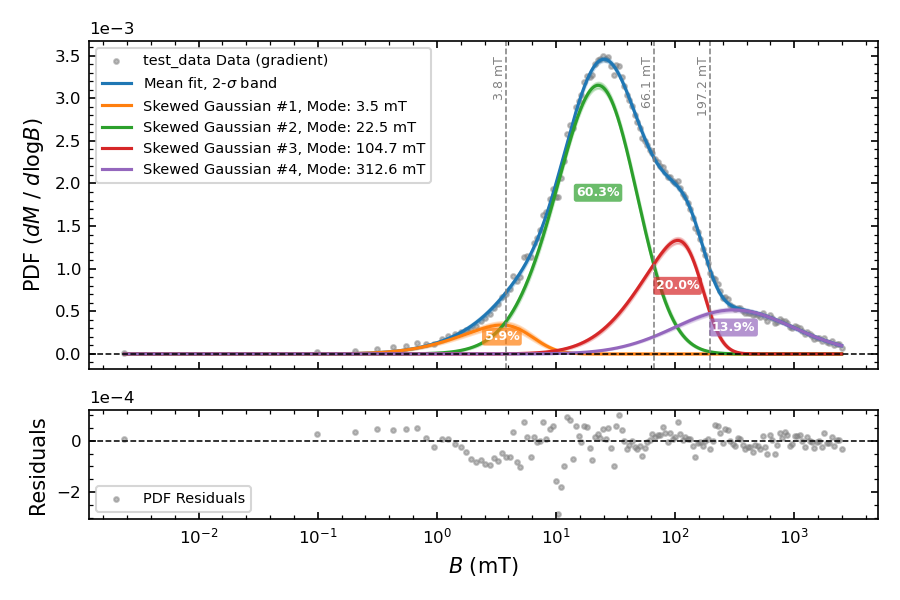

In [75]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

# PDF Plot 3

fig, (ax3, ax4) = plt.subplots(
    2, 1, figsize=(6, 4), dpi=150, sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

x_log_mT = x_log_uT - 3    # Convert to log10(mT) for plotting

# Use Tableau colors (skipping tab:blue)
component_colors = list(plt.cm.tab10.colors[1:])

# =====================================================
# PDF Plot
# =====================================================
ax3.scatter(x_log_mT, pdf, color='tab:gray', s=5, alpha=0.5, label=f"{base_name} Data Gradient")
ax3.plot(x_fine_log_mT, mean_pdf_fit_fine, '-', linewidth=1.5, color='tab:blue', label=r'Mean fit, 2-$\sigma$ band')
ax3.fill_between(x_fine_log_mT, mean_pdf_fit_fine - 2 * std_pdf_fit_fine, mean_pdf_fit_fine + 2 * std_pdf_fit_fine,
                 color='tab:blue', alpha=0.25)

# Plot each PDF component (with modes)
for i in range(n_active_components):
    mode = modes_pdf[i]

    # Round mode log BEFORE converting
    mode_log_mT_r = round(mode - 3, 3)
    mode_mT_r = round(10**mode_log_mT_r, 1)

    color = component_colors[i % len(component_colors)]
    ax3.plot(x_fine_log_mT, mean_pdf_comps_fine[i], color=color, linewidth=1.5,
             label=f'Skewed Gaussian #{i+1}, Mode: {mode_mT_r:.1f} mT')
    ax3.fill_between(x_fine_log_mT,
                     mean_pdf_comps_fine[i] - 2 * std_pdf_comps_fine[i],
                     mean_pdf_comps_fine[i] + 2 * std_pdf_comps_fine[i],
                     color=color, alpha=0.25)

# === Plot stored intersections as lines + labels ===
for i, intersection in enumerate(intersections_log_uT):
    if intersection is not None:
        # Round intersection log BEFORE converting
        intersection_log_mT_r = round(intersection - 3, 3)
        intersection_mT_r = round(10**intersection_log_mT_r, 1)

        ax3.axvline(intersection_log_mT_r, color='gray', linestyle='--', linewidth=0.75)
        ax3.text(intersection_log_mT_r, ax3.get_ylim()[1]*0.95, f'{intersection_mT_r:.1f} mT',
                 rotation=90, fontsize=6, color='gray', ha='right', va='top')

# Calculate % contribution using smooth data
component_areas = [simpson(comp, x_fine_log_uT) for comp in mean_pdf_comps_fine]
total_component_area = sum(component_areas)
component_props = [a / total_component_area for a in component_areas]

# Annotate % labels inside each PDF curve
for i in range(n_active_components):
    color = component_colors[i % len(component_colors)]
    comp = mean_pdf_comps_fine[i]
    peak_idx = np.argmax(comp)
    x_label = x_fine_log_mT[peak_idx]
    y_label = comp[peak_idx] * 0.6
    percent = component_props[i] * 100
    ax3.text(x_label, y_label, f"{percent:.1f}%", fontsize=6,
             ha='center', va='center', color='white', weight='bold',
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7))

ax3.set_ylabel(r"PDF ($dM$ / $d$log$B$)", fontsize=10)
ax3.axhline(0, color='black', linestyle='--', linewidth=0.75)
ax3.legend(loc='best', fontsize=7, frameon=True)

# =====================================================
# PDF Residuals Plot
# =====================================================
ax4.scatter(x_log_mT, pdf_residuals, color='tab:gray', s=5, alpha=0.5, label='PDF Residuals')
ax4.axhline(0, color='black', linestyle='--', linewidth=0.75)
ax4.legend(loc='best', fontsize=7, frameon=True)
ax4.set_ylabel('Residuals', fontsize=10)
ax4.set_xlabel(r'$B$ (mT)', fontsize=10)

# =====================================================
# Apply consistent formatting to all subplots
# =====================================================
for ax in [ax1, ax2, ax3, ax4]:
    ax.minorticks_on()
    ax.tick_params(which='both', labelsize=8, top=True, right=True, direction='in')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(8)

# === Tidy up X-axis (log labels) ===
def log_formatter(x, pos):
    if np.isclose(x, round(x), atol=1e-6):
        return f'$10^{{{int(x)}}}$'
    else:
        return ''
for ax in [ax1, ax2, ax3, ax4]:
    ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))

# ==============================================================
# Final layout and Save
# ==============================================================
fig.tight_layout()

fig_name = f"{base_name}_PDF.{save_format}"
plt.savefig(fig_name, dpi=300, bbox_inches='tight')
print(f"Figure saved as: {fig_name}")

plt.show()

#### Plot 4: CDF

Figure saved as: test_data_CDF.png


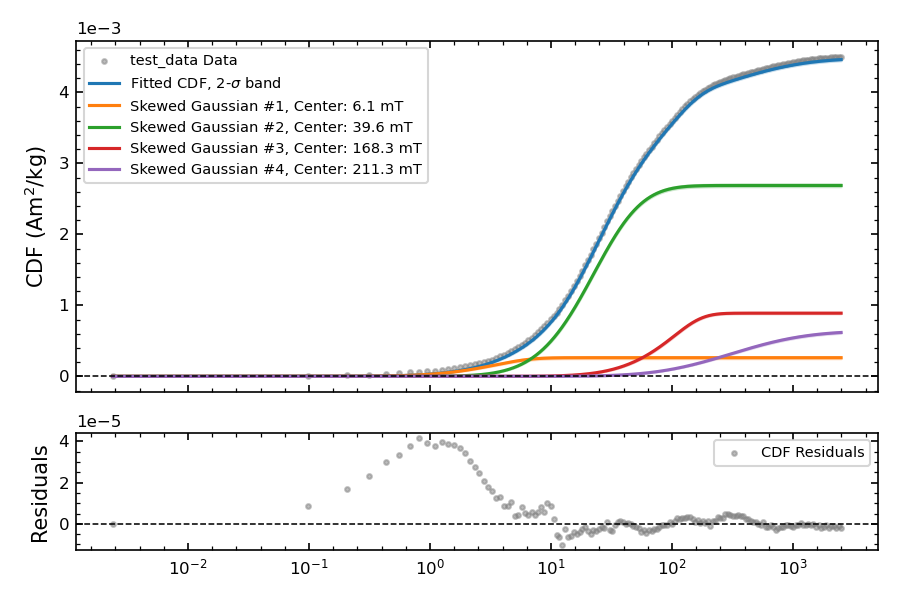

In [76]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

# CDF Plot 4

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 4), dpi=150, sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

x_log_mT = x_log_uT - 3    # Convert to log10(mT) for plotting

# Use Tableau colors (skipping tab:blue)
component_colors = list(plt.cm.tab10.colors[1:])

# =====================================================
# CDF Plot
# =====================================================
ax1.scatter(x_log_mT, cdf, color='tab:gray', s=5, alpha=0.5, label=f"{base_name} Data")
ax1.plot(x_fine_log_mT, mean_cdf_fit_fine, '-', color='tab:blue', linewidth=1.5, label='Fitted CDF, 2-$\sigma$ band')
ax1.fill_between(x_fine_log_mT, mean_cdf_fit_fine - std_cdf_fit_fine, mean_cdf_fit_fine + std_cdf_fit_fine,
                 color='tab:blue', alpha=0.25)
ax1.set_ylabel(r'CDF (Am$^2$/kg)', fontsize=10)

# Plot each CDF component
for i in range(n_active_components):
    amp, cen, sig, skw = optimized_params_cdf[i*4:i*4+4]

    # Round log BEFORE converting to mT for consistency
    center_log_mT_r = round(cen - 3, 3)
    center_mT_r = round(10**center_log_mT_r, 1)

    color = component_colors[i % len(component_colors)]
    ax1.plot(x_fine_log_mT, mean_cdf_comps_fine[i], color=color,
             label=f'Skewed Gaussian #{i+1}, Center: {center_mT_r:.1f} mT')
    ax1.fill_between(x_fine_log_mT,
                     mean_cdf_comps_fine[i] - std_cdf_comps_fine[i],
                     mean_cdf_comps_fine[i] + std_cdf_comps_fine[i],
                     color=color, alpha=0.25)

ax1.legend(loc='best', fontsize=7, frameon=True)
ax1.axhline(0, color='black', linestyle='--', linewidth=0.75)

# =====================================================
# CDF Residuals Plot
# =====================================================
ax2.scatter(x_log_mT, cdf_residuals, color='tab:gray', s=5, alpha=0.5, label='CDF Residuals')
ax2.set_ylabel('Residuals', fontsize=10)
ax2.legend(loc='best', fontsize=7, frameon=True)
ax2.axhline(0, color='black', linestyle='--', linewidth=0.75)

# =====================================================
# Apply consistent formatting to all subplots
# =====================================================
for ax in [ax1, ax2]:
    ax.minorticks_on()
    ax.tick_params(which='both', labelsize=8, top=True, right=True, direction='in')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(8)

# === Tidy up X-axis (log labels) ===
def log_formatter(x, pos):
    if np.isclose(x, round(x), atol=1e-6):
        return f'$10^{{{int(x)}}}$'
    else:
        return ''
for ax in [ax1, ax2, ax3, ax4]:
    ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))

# ==============================================================
# Final layout and Save
# ==============================================================
fig.tight_layout()

fig_name = f"{base_name}_CDF.{save_format}"
plt.savefig(fig_name, dpi=300, bbox_inches='tight')
print(f"Figure saved as: {fig_name}")

plt.show()

## Optimized Parameter Printout and Save to CVS

In [77]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

# ==============================================================
# Save and Print Optimized Fit Summary (intersections fully in mT)
# ==============================================================

save_csv = True   # Toggle this to False if you just want console output, no CSV written
output_file = f"{base_name}_optimized_components.csv"

if save_csv:
    file = open(output_file, mode='w', newline='')
    writer = csv.writer(file)
    # --- Write header for components ---
    writer.writerow([
        "Component", "Amplitude", "Center (log mT)", "Center (mT)",
        "Mode (log mT)", "Mode (mT)", "Sigma", "Skew", "Percent Area (%)"
    ])

# --- Write and print component details ---
for i in range(n_active_components):
    amplitude = optimized_params_cdf[i * 4]
    center_log_uT = optimized_params_cdf[i * 4 + 1]
    sigma = optimized_params_cdf[i * 4 + 2]
    skew = optimized_params_cdf[i * 4 + 3]
    mode_log_uT = modes_pdf[i]

    # Convert from µT → mT
    center_log_mT = center_log_uT - 3
    mode_log_mT = mode_log_uT - 3

    # Round logs to 3 decimals, then calculate linear values
    center_log_mT_r = round(center_log_mT, 3)
    center_mT_r = round(10 ** center_log_mT_r, 1)
    mode_log_mT_r = round(mode_log_mT, 3)
    mode_mT_r = round(10 ** mode_log_mT_r, 1)
    percent = round(component_props[i] * 100, 1)

    # --- Write to CSV if enabled ---
    if save_csv:
        writer.writerow([
            f"Component {i + 1}",
            f"{amplitude:.8f}",
            f"{center_log_mT_r:.3f}",
            f"{center_mT_r:.1f}",
            f"{mode_log_mT_r:.3f}",
            f"{mode_mT_r:.1f}",
            f"{sigma:.2f}",
            f"{skew:.2f}",
            f"{percent:.1f}"
        ])

    # --- Print nicely to screen ---
    display(Markdown(
        f"**Component {i + 1}:** "
        f"Amplitude = {amplitude:.8f}; "
        f"Center = {center_log_mT_r:.3f} (log mT), {center_mT_r:.1f} mT; "
        f"Mode = {mode_log_mT_r:.3f} (log mT), {mode_mT_r:.1f} mT; "
        f"Sigma = {sigma:.2f}; Skew = {skew:.2f}; "
        f"Percent Area = {percent:.1f}%"
    ))

# --- Empty row and intersections section ---
if save_csv:
    writer.writerow([])
    writer.writerow(["Intersection #", "log10(mT)", "mT"])

# --- Write/print intersections ---
for i, intersection in enumerate(intersections_log_uT):
    if intersection is not None:
        # Convert intersections to log10(mT) and mT consistently
        intersection_log_mT = intersection - 3
        intersection_log_mT_r = round(intersection_log_mT, 3)
        intersection_mT_r = round(10 ** intersection_log_mT_r, 1)

        if save_csv:
            writer.writerow([
                f"Between {i + 1}–{i + 2}",
                f"{intersection_log_mT_r:.3f}",
                f"{intersection_mT_r:.1f}"
            ])
        display(Markdown(
            f"**Intersection {i + 1}–{i + 2}:** {intersection_log_mT_r:.3f} log(mT) = {intersection_mT_r:.1f} mT"
        ))
    else:
        if save_csv:
            writer.writerow([f"Between {i + 1}–{i + 2}", "None", "None"])
        display(Markdown(f"**Intersection {i + 1}–{i + 2}:** None"))

if save_csv:
    file.close()
    print(f"\nOptimized component parameters and intersections saved to `{output_file}`.")
else:
    print("\nCSV saving skipped; summary printed only.")

**Component 1:** Amplitude = 0.00029793; Center = 0.786 (log mT), 6.1 mT; Mode = 0.542 (log mT), 3.5 mT; Sigma = 0.50; Skew = 2.79; Percent Area = 5.9%

**Component 2:** Amplitude = 0.00269118; Center = 1.598 (log mT), 39.6 mT; Mode = 1.352 (log mT), 22.5 mT; Sigma = 0.46; Skew = 1.38; Percent Area = 60.3%

**Component 3:** Amplitude = 0.00089378; Center = 2.226 (log mT), 168.3 mT; Mode = 2.020 (log mT), 104.7 mT; Sigma = 0.45; Skew = 3.32; Percent Area = 20.0%

**Component 4:** Amplitude = 0.00064289; Center = 2.325 (log mT), 211.3 mT; Mode = 2.495 (log mT), 312.6 mT; Sigma = 0.53; Skew = -0.46; Percent Area = 13.9%

**Intersection 1–2:** 0.577 log(mT) = 3.8 mT

**Intersection 2–3:** 1.820 log(mT) = 66.1 mT

**Intersection 3–4:** 2.295 log(mT) = 197.2 mT


Optimized component parameters and intersections saved to `test_data_optimized_components.csv`.


In [78]:
# **************************************************************
# RUN THIS CELL AS IS
# **************************************************************

# ==============================================================
# Close All Figures to Save Memory
# ==============================================================
plt.close('all')